In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from distutils.dir_util import copy_tree, remove_tree
from random import randint
from PIL import Image
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.utils.vis_utils import plot_model



In [2]:
root_dir ='./'
base_dir = '../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/'
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"
if os.path.exists(work_dir):
    remove_tree(work_dir)
os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))    


Working Directory Contents: ['MildDemented', 'ModerateDemented', 'VeryMildDemented', 'NonDemented']


In [3]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [4]:
ZOOM_RANGE = [0.99,1.01]
BRIGHT_RANGE = [0.8,1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"
work_dr = IDG(rescale=1./255, brightness_range = BRIGHT_RANGE, zoom_range = ZOOM_RANGE, data_format = DATA_FORMAT,
            fill_mode = FILL_MODE, horizontal_flip = HORZ_FLIP)

In [5]:
train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


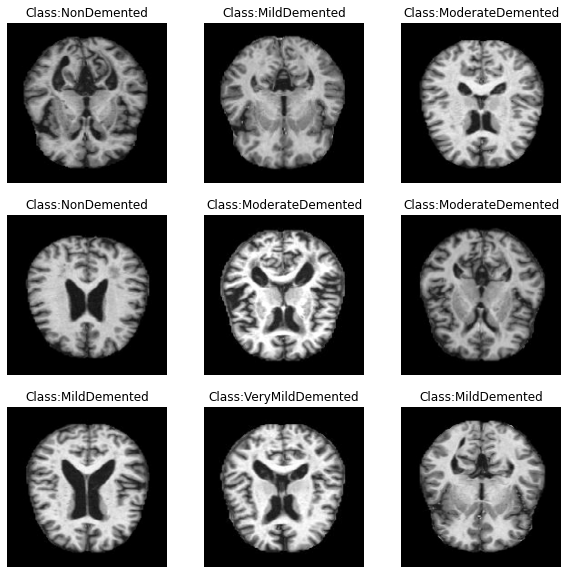

In [6]:
def show_images(generator, y_pred=None):
    labels = dict(zip([0,1,2,3], CLASSES))
    x,y = generator.next()
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3,3,i+1)
            idx = randint(0,6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
show_images(train_data_gen)
        
        


In [8]:
train_data, train_labels = train_data_gen.next()
print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [9]:
sm = SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)
train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [10]:
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [12]:
EfficientNetB7_model = EfficientNetB7(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

258080768/258076736 [==============================] - 2s 0us/step


In [14]:
for layer in EfficientNetB7_model.layers:
    layer.trainable=False

In [15]:
custom_EfficientNetB7_model = Sequential([
        EfficientNetB7_model,
        Dropout(0.5),
        GlobalMaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "EfficientNetB7_cnn_model")

In [14]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [15]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback, rop_callback]
    
custom_InceptionResNetV2_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_InceptionResNetV2_model.summary()

Model: "InceptionResNetV2_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 1536)        0         
_________________________________________________________________
global_max_pooling2d (Global (None, 1536)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
batch_normalization_203 (Bat (None, 1536)              6144      
_________________________________________________________________
dense (Dense)                (None, 512)               786944    
_________________________________________________________________
batch_normalization_204 (Bat (None, 512

In [16]:
EPOCHS = 100
history = custom_InceptionResNetV2_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/100
164/164 [==============================] - 39s 142ms/step - loss: 1.6512 - acc: 0.3091 - auc: 0.5688 - f1_score: 0.3084 - val_loss: 1.0721 - val_acc: 0.5065 - val_auc: 0.7844 - val_f1_score: 0.5120
Epoch 2/100
164/164 [==============================] - 18s 108ms/step - loss: 1.1443 - acc: 0.4810 - auc: 0.7620 - f1_score: 0.4727 - val_loss: 1.3565 - val_acc: 0.4073 - val_auc: 0.6704 - val_f1_score: 0.3837
Epoch 3/100
164/164 [==============================] - 17s 106ms/step - loss: 0.9172 - acc: 0.5725 - auc: 0.8443 - f1_score: 0.5676 - val_loss: 1.2063 - val_acc: 0.4165 - val_auc: 0.7126 - val_f1_score: 0.3982
Epoch 4/100
164/164 [==============================] - 18s 108ms/step - loss: 0.8430 - acc: 0.6155 - auc: 0.8704 - f1_score: 0.6118 - val_loss: 0.9036 - val_acc: 0.5736 - val_auc: 0.8487 - val_f1_score: 0.5362
Epoch 5/100
164/164 [==============================] - 18s 108ms/step - loss: 0.7656 - acc: 0.6564 - auc: 0.8938 - f1_score: 0.6489 - val_loss: 1.4675 - val_acc

In [17]:
test_scores = custom_InceptionResNetV2_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

52/52 [==============================] - 5s 87ms/step - loss: 1.2868 - acc: 0.4259 - auc: 0.7024 - f1_score: 0.3859
Testing Accuracy: 42.59%


In [18]:
pred_lab = custom_InceptionResNetV2_model.predict(test_data)

In [19]:
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_lab:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_lab, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.73      0.06      0.11       399
VeryMildDemented       1.00      0.20      0.34       414
    MildDemented       0.67      0.70      0.69       391
ModerateDemented       0.28      0.72      0.41       435

       micro avg       0.43      0.43      0.43      1639
       macro avg       0.67      0.42      0.39      1639
    weighted avg       0.67      0.43      0.38      1639
     samples avg       0.43      0.43      0.43      1639



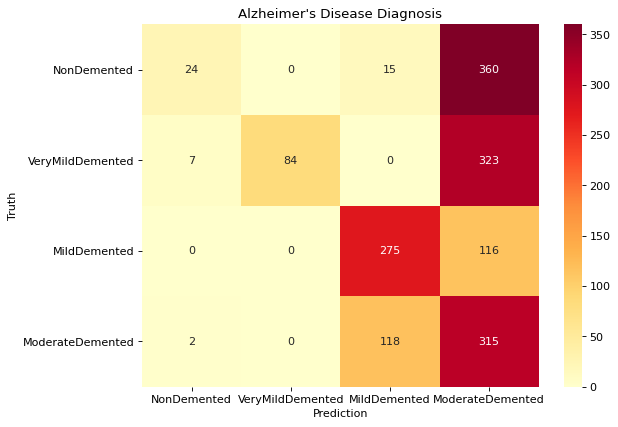

<Figure size 432x288 with 0 Axes>

In [20]:
pred_ls = np.argmax(pred_lab, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='YlOrRd', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)
plt.savefig(work_dir+'custom_InceptionResNetV2_confusion_final.png')



In [22]:
custom_InceptionResNetV2_model_dir = work_dir + "custom_InceptionResNetV2_cnn_model"
custom_InceptionResNetV2_model.save(custom_InceptionResNetV2_model_dir, save_format='h5')
os.listdir(work_dir)

['ModerateDemented',
 'custom_InceptionResNetV2_cnn_model',
 'VeryMildDemented',
 'custom_InceptionResNetV2_confusion_final.png',
 'MildDemented',
 'NonDemented']

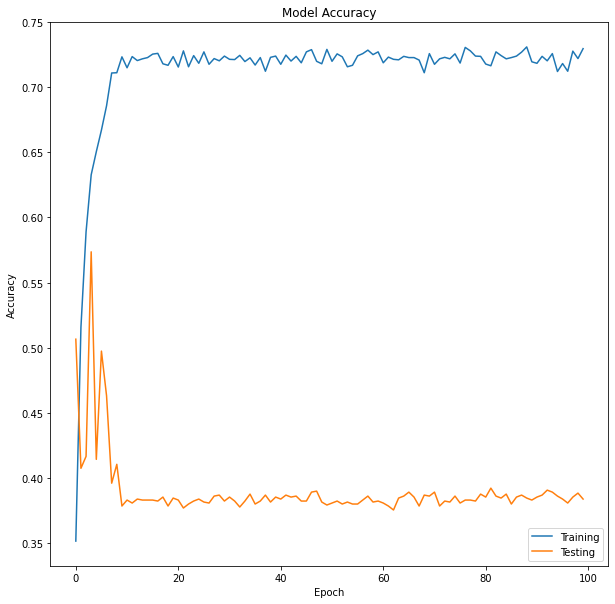

In [23]:
plt.figure(figsize=(10,10))
 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
 
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
 
plt.legend(['Training', 'Testing'])
plt.savefig(work_dir+'custom_InceptionResNetV2_accuracy_final.png')
plt.show()

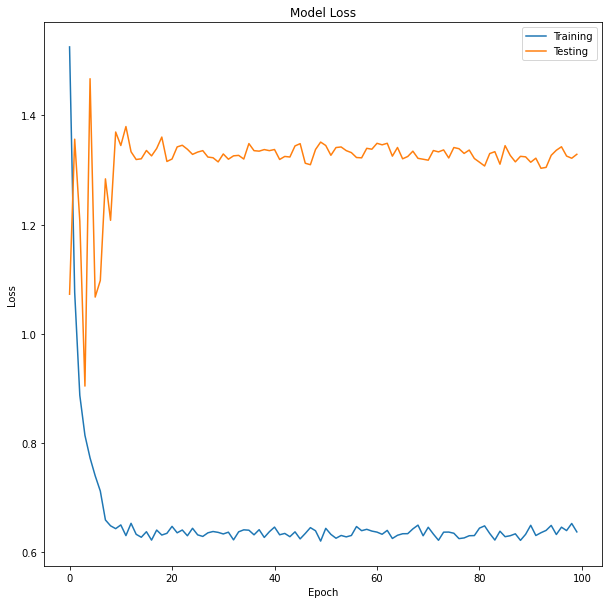

In [26]:
plt.figure(figsize=(10,10))
 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
 
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
 
plt.legend(['Training', 'Testing'])
plt.savefig(work_dir+'custom_InceptionResNetV2_loss_final.png')
plt.show()

In [25]:
# prediction=pred_lab[1:10]
# for index, probability in enumerate(prediction):
#   if probability.item(0) > 0.5:
#         plt.title('%.2f' % (probability.item(0)*100) + '% Demented')
#   else:
#         plt.title('%.2f' % ((1-probability.item(0))*100) + '% NonDemented')
#   plt.style.reload_library
#   plt.imshow(test_data[index])
#   plt.show()
# show_images(train_data_gen,pred_lab)

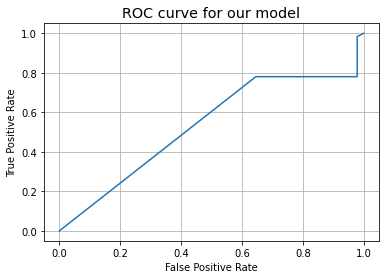

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score
pred_ls = np.argmax(pred_lab, axis=1)
test_ls = np.argmax(test_labels, axis=1)
fpr, tpr, thresholds = roc_curve(test_ls, pred_ls,pos_label=True)
# auc = roc_auc_score(test_ls, pred_ls)
# print('AUC: %.3f' % auc)
plt.plot(fpr, tpr)
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig(work_dir+'custom_InceptionResNetV2_ROC_final.png')
plt.grid(True)


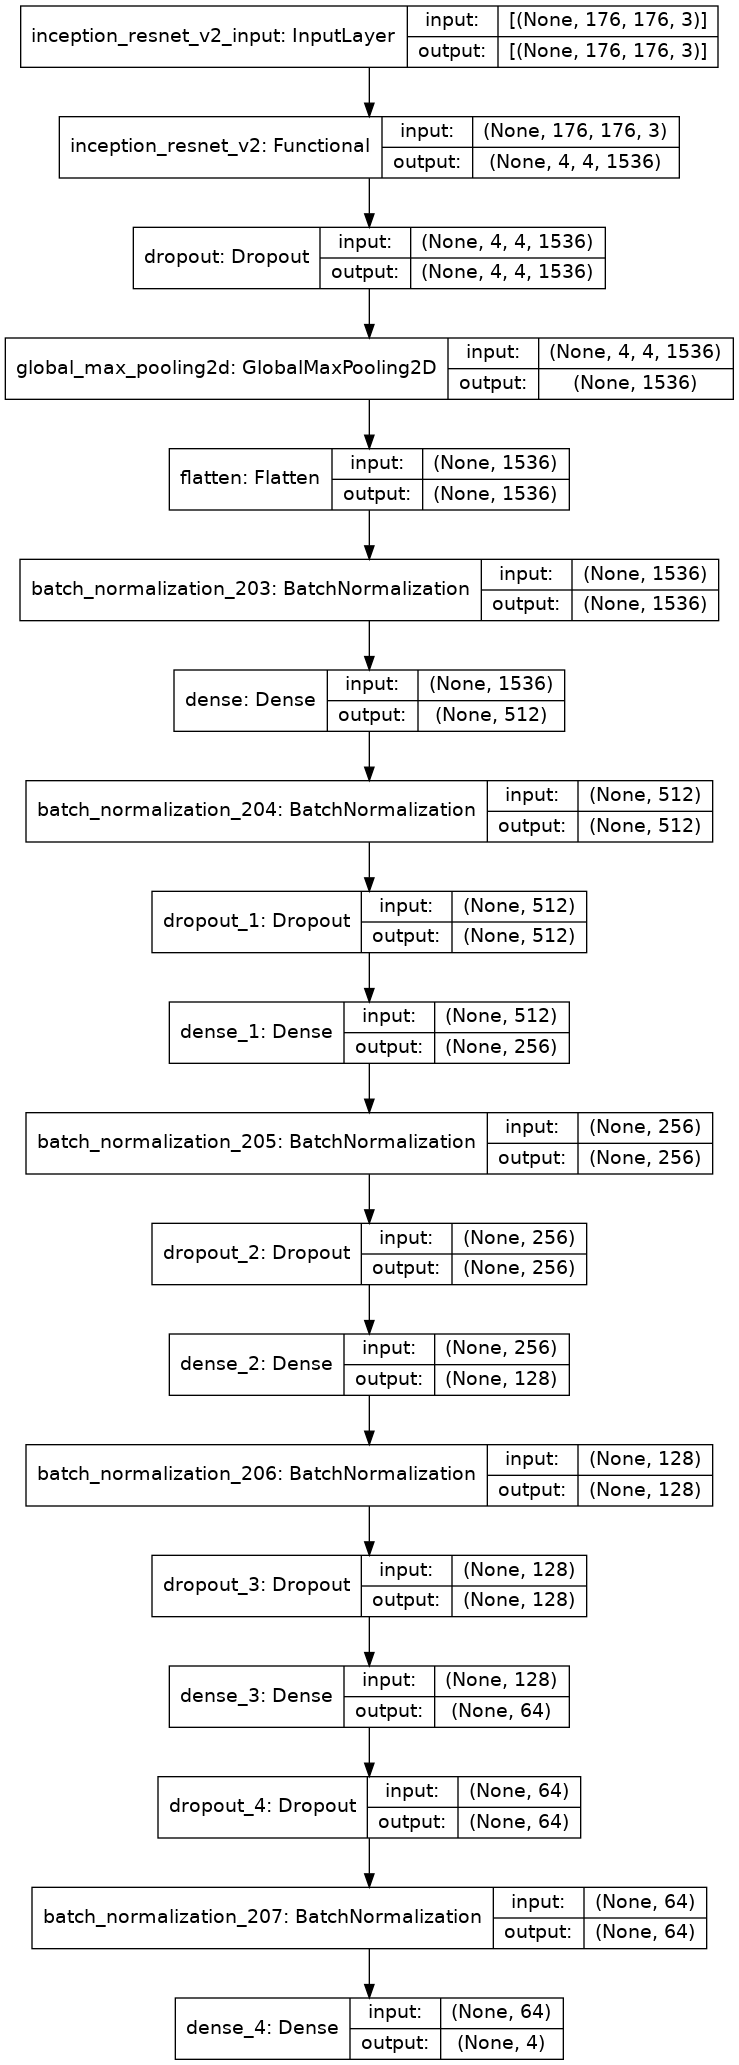

In [28]:
pretrained_model = tf.keras.models.load_model(custom_VGG19_model_dir)
plot_model(pretrained_model, to_file=work_dir + "custom_InceptionResNetV2_architecture_plot.png", show_shapes=True, show_layer_names=True)
